In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import os
import matplotlib.pyplot as plt

In [2]:
### to change according to your machine
base_dir = os.path.expanduser("~/data/tianchi-german/data")

path_training = os.path.join(base_dir, 'validation.h5')
path_validation = os.path.join(base_dir, 'validation.h5')
path_test = os.path.join(base_dir, 'round1_test_a_20181109.h5')

fid_training = h5py.File(path_training, 'r')
fid_validation = h5py.File(path_validation, 'r')
fid_test = h5py.File(path_test, 'r')

In [3]:
## we can have a look at which keys are stored in the file
## you will get the return [u'label', u'sen1', u'sen2']
## sen1 and sen2 means the satellite images
print(list(fid_training.keys()))
print(list(fid_validation.keys()))
print(list(fid_test.keys()))

['label', 'sen1', 'sen2']
['label', 'sen1', 'sen2']
['sen1', 'sen2']


In [4]:
### get s1 image channel data
### it is not really loaded into memory. only the indexes have been loaded.
print("training part")
s1_training = fid_training['sen1']
print(s1_training.shape)
s2_training = fid_training['sen2']
print(s2_training.shape)
label_training = fid_training['label']
print(label_training.shape)

print("-" * 60)
print("validation part")
s1_validation = fid_validation['sen1']
print(s1_validation.shape)
s2_validation = fid_validation['sen2']
print(s2_validation.shape)
label_validation = fid_validation['label']
print(label_validation.shape)

print("-" * 60)
print("test part")
s1_test = fid_test['sen1']
print(s1_test.shape)
s2_test = fid_test['sen2']
print(s2_test.shape)

training part
(24119, 32, 32, 8)
(24119, 32, 32, 10)
(24119, 17)
------------------------------------------------------------
validation part
(24119, 32, 32, 8)
(24119, 32, 32, 10)
(24119, 17)
------------------------------------------------------------
test part
(4838, 32, 32, 8)
(4838, 32, 32, 10)


In [5]:
print("label_training[0]: ", label_training[0])

label_training[0]:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


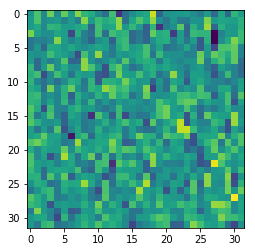

In [6]:
plt.imshow(s1_training[0, :, :, 0])
plt.show()

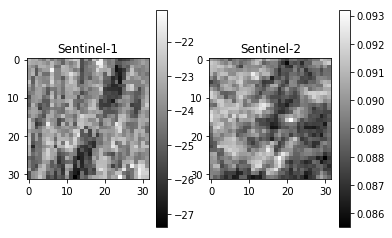

In [7]:
## compute the quantity for each col
label_qty = np.sum(label_training, axis=0)

plt.plot(label_qty)

plt.subplot(121)
plt.imshow(10 * np.log10(s1_training[0, :, :, 4]), cmap=plt.cm.get_cmap('gray'))
plt.colorbar()
plt.title('Sentinel-1')

plt.subplot(122)
plt.imshow(s2_training[0, :, :, 1], cmap=plt.cm.get_cmap('gray'))
plt.colorbar()
plt.title('Sentinel-2')

plt.show()

In [8]:
### simple classification example
### Training part

from sklearn.linear_model import SGDClassifier

train_s1 = s1_training
train_s2 = s2_training
train_label = label_training
clf = SGDClassifier()

train_y = np.argmax(train_label, axis=1)
classes = list(set(train_y))
batch_size = 100000
n_sampels = train_s1.shape[0]

for i in range(0, n_sampels, batch_size):
    ## this is an idea for batch training
    ## you can relpace this loop for deep learning methods
    if i % batch_size * 10 == 0:
        print("done %d/%d" % (i, n_sampels))
    start_pos = i
    end_pos = min(i + batch_size, n_sampels)
    train_s1_batch = np.asarray(train_s1[start_pos:end_pos, :, :, :])
    train_s2_batch = np.asarray(train_s2[start_pos:end_pos, :, :, :])
    cur_batch_size = train_s2_batch.shape[0]
    train_s1_batch = train_s1_batch.reshape((cur_batch_size, -1))
    train_s2_batch = train_s2_batch.reshape((cur_batch_size, -1))
    train_X_batch = np.hstack([train_s1_batch, train_s2_batch])
    label_batch = train_y[start_pos:end_pos]
    clf.partial_fit(train_X_batch, label_batch, classes=classes)

### make a prediction on validation
pred_y = []
train_val_y = np.argmax(label_validation, axis=1)
batch_size = 10000
n_val_samples = s2_validation.shape[0]
for i in range(0, n_val_samples, batch_size):
    start_pos = i
    end_pos = min(i + batch_size, n_val_samples)
    val_s1_batch = np.asarray(s1_validation[start_pos:end_pos, :, :, :])
    val_s2_batch = np.asarray(s2_validation[start_pos:end_pos, :, :, :])
    cur_batch_size = val_s2_batch.shape[0]
    val_s1_batch = val_s1_batch.reshape((cur_batch_size, -1))
    val_s2_batch = val_s2_batch.reshape((cur_batch_size, -1))
    val_X_batch = np.hstack([val_s1_batch, val_s2_batch])
    tmp_pred_y = clf.predict(val_X_batch)
    pred_y.append(tmp_pred_y)
pred_y = np.hstack(pred_y)

print(classification_report(train_val_y, pred_y))

done 0/24119


/Users/mvpzhao/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


             precision    recall  f1-score   support

          0       0.18      0.14      0.16       256
          1       0.27      0.17      0.21      1254
          2       0.12      0.31      0.17      2353
          3       0.16      0.08      0.11       849
          4       0.12      0.03      0.04       757
          5       0.15      0.02      0.04      1906
          6       0.10      0.01      0.01       474
          7       0.29      0.60      0.39      3395
          8       0.47      0.01      0.03      1914
          9       0.19      0.09      0.12       860
         10       0.66      0.67      0.67      2287
         11       0.03      0.13      0.05       382
         12       0.88      0.54      0.67      1202
         13       0.58      0.25      0.35      2747
         14       0.00      0.00      0.00       202
         15       0.00      0.00      0.00       672
         16       0.94      0.90      0.92      2609

avg / total       0.41      0.35      0.34  

In [9]:
pred_y.shape

(24119,)